# Configuration

## Useful Functions

In [ ]:
def calc_rdms(model_features, method="correlation"):
    """
    Calculates representational dissimilarity matrices (RDMs) for model features.

    Inputs:
    - model_features (dict): A dictionary where keys are layer names and values are features of the layers.
    - method (str): The method to calculate RDMs, e.g., 'correlation'. Default is 'correlation'.

    Outputs:
    - rdms (pyrsa.rdm.RDMs): RDMs object containing dissimilarity matrices.
    - rdms_dict (dict): A dictionary with layer names as keys and their corresponding RDMs as values.
    """
    ds_list = []
    for l in range(len(model_features)):
        layer = list(model_features.keys())[l]
        feats = model_features[layer]

        if type(feats) is list:
            feats = feats[-1]

        feats = feats.cpu()

        if len(feats.shape) > 2:
            feats = feats.flatten(1)

        feats = feats.detach().numpy()
        ds = Dataset(feats, descriptors=dict(layer=layer))
        ds_list.append(ds)

    rdms = calc_rdm(ds_list, method=method)
    rdms_dict = {
        list(model_features.keys())[i]: rdms.get_matrices()[i]
        for i in range(len(model_features))
    }

    return rdms, rdms_dict


def extract_features(model, imgs, return_layers, plot="none"):
    """
    Extracts features from specified layers of the model.

    Inputs:
    - model (torch.nn.Module): The model from which to extract features.
    - imgs (torch.Tensor): Batch of input images.
    - return_layers (list): List of layer names from which to extract features.
    - plot (str): Option to plot the features. Default is 'none'.

    Outputs:
    - model_features (dict): A dictionary with layer names as keys and extracted features as values.
    """
    model_history = tl.log_forward_pass(model, imgs, layers_to_save="all", vis_opt=plot)
    model_features = {}
    for layer in return_layers:
        model_features[layer] = model_history[layer].tensor_contents.flatten(1)

    return model_features


# Use this correct version of the function


def extract_features(model, imgs, return_layers):
    """
    Extracts features from specified layers of the model using PyTorch's
    built-in feature extractor.
    """
    if return_layers == "all":
        # Automatically get the names of all layers in the model
        return_layers, _ = get_graph_node_names(model)

    # Create the feature extractor
    feature_extractor = create_feature_extractor(model, return_nodes=return_layers)
    model_features = feature_extractor(imgs)

    # Re-key with simple integer indices for easier plotting and add the input layer
    final_features = {i: v for i, (k, v) in enumerate(model_features.items())}
    final_features[-1] = imgs  # Add input layer with key -1

    # Sort the dictionary by layer index to ensure the correct processing order
    final_features = dict(sorted(final_features.items()))

    return final_features


def extract_features(model, imgs, return_layers):
    """
    Extracts features using PyTorch's built-in feature extractor.
    """
    # THIS IS THE MISSING PART: It handles the 'all' keyword for the path analysis
    if isinstance(return_layers, str) and return_layers == "all":
        # Automatically get the names of all layers in the model
        return_layers, _ = get_graph_node_names(model)

    # Create the feature extractor
    feature_extractor = create_feature_extractor(model, return_nodes=return_layers)
    model_features = feature_extractor(imgs)
    return model_features


def rep_path(
    model_features,
    model_colors,
    labels=None,
    rdm_calc_method="euclidean",
    rdm_comp_method="cosine",
):
    """
    Represents paths of model features in a reduced-dimensional space.
    """
    path_len = []
    path_colors = []
    rdms_list = []
    ax_ticks = []
    tick_colors = []
    model_names = list(model_features.keys())

    for model_name in model_names:
        features = model_features[model_name]
        path_colors.append(model_colors[model_name])
        path_len.append(len(features))
        ax_ticks.append(list(features.keys()))
        tick_colors.append([model_colors[model_name]] * len(features))
        rdms, _ = calc_rdms(features, method=rdm_calc_method)
        rdms_list.append(rdms)

    if labels is not None:
        device = labels.device
        rdms_labels_obj, _ = calc_rdms(
            {"labels": F.one_hot(labels).float().to(device)}, method=rdm_calc_method
        )
        rdms_list.append(rdms_labels_obj)
        ax_ticks.append(["labels"])
        tick_colors.append(["m"])

    # --- START OF DEBUGGING CODE ---
    print("--- Debugging RDM Shapes Before Concatenation ---")
    for i, rdm_obj in enumerate(rdms_list):
        print(f"Object {i}: n_rdm={rdm_obj.n_rdm}, n_cond={rdm_obj.n_cond}")
    print("-------------------------------------------------")
    # --- END OF DEBUGGING CODE ---

    # Combine all RDMs
    rdms = rsatoolbox.rdm.concat(
        rdms_list
    )  # This is the line that was causing the error

    # ... (rest of the function is the same) ...
    # Flatten the lists for labels and colors
    ax_ticks = [l for model_layers in ax_ticks for l in model_layers]
    tick_colors = [l for model_layers in tick_colors for l in model_layers]

    # Compare RDMs to each other to create a meta-dissimilarity matrix
    rdms_comp = rsatoolbox.rdm.compare(rdms, rdms, method=rdm_comp_method)
    if rdm_comp_method == "cosine":
        rdms_comp = np.arccos(rdms_comp)
    rdms_comp = np.nan_to_num(rdms_comp, nan=0.0)
    rdms_comp = (rdms_comp + rdms_comp.T) / 2.0  # Symmetrize

    # Use MDS to reduce the meta-matrix to 2D for plotting
    mds = manifold.MDS(
        n_components=2,
        max_iter=1000,
        n_init=10,
        dissimilarity="precomputed",
        normalized_stress="auto",
    )
    dims = mds.fit_transform(rdms_comp)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the RDM-of-RDMs
    im = ax1.imshow(rdms_comp, cmap="viridis_r")
    fig.colorbar(im, ax=ax1, label="Dissimilarity between RDMs")
    ax1.set_title("Layer-by-Layer RDM Dissimilarity")
    ax1.set_xticks(np.arange(len(ax_ticks)))
    ax1.set_xticklabels(ax_ticks, rotation=90)
    ax1.set_yticks(np.arange(len(ax_ticks)))
    ax1.set_yticklabels(ax_ticks)

    # Plot the 2D representational path
    for i in range(len(model_names)):
        path_indices = np.arange(path_len[i], path_len[i + 1])
        ax2.plot(
            dims[path_indices, 0],
            dims[path_indices, 1],
            color=path_colors[i],
            marker=".",
            label=model_names[i],
        )

    # Plot input and label points
    try:
        idx_input = ax_ticks.index(-1)  # The input layer
        ax2.plot(
            dims[idx_input, 0],
            dims[idx_input, 1],
            color="k",
            marker="s",
            markersize=8,
            label="Input",
        )
        if labels is not None:
            idx_labels = ax_ticks.index("labels")
            ax2.plot(
                dims[idx_labels, 0],
                dims[idx_labels, 1],
                color="m",
                marker="*",
                markersize=10,
                label="Labels",
            )
    except ValueError:
        print(
            "Could not find 'input' or 'labels' in ticks for plotting special markers."
        )

    ax2.set_title("Representational Geometry Path")
    ax2.set_xlabel("MDS Dimension 1")
    ax2.set_ylabel("MDS Dimension 2")
    ax2.legend()
    fig.tight_layout()
    plt.show()


# REPLACE your rep_path function with this final, corrected version


def rep_path(
    model_features,
    model_colors,
    labels=None,
    rdm_calc_method="euclidean",
    rdm_comp_method="cosine",
):
    """
    Represents and plots the representational paths of models. (Corrected Version)
    """
    model_names = list(model_features.keys())
    path_lens_raw, rdms_list, ax_ticks = [], [], []

    # Loop through models to get RDMs and layer info
    for model_name in model_names:
        features = model_features[model_name]
        path_lens_raw.append(len(features))
        ax_ticks.append(
            [str(k) for k in features.keys()]
        )  # Use string keys for robustness
        rdms_obj, _ = calc_rdms(features, method=rdm_calc_method)
        rdms_list.append(rdms_obj)

    # Handle labels RDM if provided
    if labels is not None:
        rdms_labels_obj, _ = calc_rdms(
            {"labels": F.one_hot(labels).float()}, method=rdm_calc_method
        )
        rdms_list.append(rdms_labels_obj)
        ax_ticks.append(["labels"])

    # --- FIX for IndexError ---
    # Create cumulative path lengths which will be used for slicing the plot data
    path_indices_cumulative = np.insert(np.cumsum(path_lens_raw), 0, 0)

    # Combine all RDMs and create the meta-dissimilarity matrix
    rdms_all = rsatoolbox.rdm.concat(rdms_list)
    ax_ticks_flat = [tick for model_layers in ax_ticks for tick in model_layers]
    rdms_comp = rsatoolbox.rdm.compare(rdms_all, rdms_all, method=rdm_comp_method)

    # --- FIX for RuntimeWarning ---
    # Clip values to be within the valid range for arccos [-1, 1]
    rdms_comp = np.clip(rdms_comp, -1, 1)

    if rdm_comp_method == "cosine":
        rdms_comp = np.arccos(rdms_comp)
    rdms_comp = np.nan_to_num(rdms_comp, nan=0.0)
    rdms_comp = (rdms_comp + rdms_comp.T) / 2.0

    # Use MDS to reduce to 2D for plotting
    mds = manifold.MDS(
        n_components=2,
        max_iter=1000,
        n_init=10,
        dissimilarity="precomputed",
        normalized_stress="auto",
    )
    dims = mds.fit_transform(rdms_comp)

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))

    # Correctly loop and slice to plot each model's path
    for i, model_name in enumerate(model_names):
        start_index = path_indices_cumulative[i]
        end_index = path_indices_cumulative[i + 1]
        ax.plot(
            dims[start_index:end_index, 0],
            dims[start_index:end_index, 1],
            color=model_colors[model_name],
            marker=".",
            label=model_name,
        )

    # Plot special markers for input and labels
    try:
        idx_input = ax_ticks_flat.index("-1")
        ax.plot(
            dims[idx_input, 0],
            dims[idx_input, 1],
            color="k",
            marker="s",
            markersize=8,
            label="Input",
        )
        if labels is not None:
            idx_labels = ax_ticks_flat.index("labels")
            ax.plot(
                dims[idx_labels, 0],
                dims[idx_labels, 1],
                color="m",
                marker="*",
                markersize=10,
                label="Labels",
            )
    except ValueError:
        print("Warning: Could not find 'Input' or 'Labels' markers.")

    ax.set_title("Representational Geometry Path (BP vs. PC)")
    ax.set_xlabel("MDS Dimension 1")
    ax.set_ylabel("MDS Dimension 2")
    ax.legend()
    plt.tight_layout()
    plt.show()


# REPLACE your rep_path function with this final version


def rep_path(
    model_features,
    model_colors,
    labels=None,
    rdm_calc_method="euclidean",
    rdm_comp_method="cosine",
):
    """
    Represents and plots the representational paths of models. (Final Version)
    """
    model_names = list(model_features.keys())
    path_lens_raw, rdms_list, ax_ticks = [], [], []

    for model_name in model_names:
        features = model_features[model_name]
        path_lens_raw.append(len(features))
        ax_ticks.append([str(k) for k in features.keys()])
        rdms_obj, _ = calc_rdms(features, method=rdm_calc_method)
        rdms_list.append(rdms_obj)

    if labels is not None:
        rdms_labels_obj, _ = calc_rdms(
            {"labels": F.one_hot(labels).float()}, method=rdm_calc_method
        )
        rdms_list.append(rdms_labels_obj)
        ax_ticks.append(["labels"])

    path_indices_cumulative = np.insert(np.cumsum(path_lens_raw), 0, 0)
    rdms_all = rsatoolbox.rdm.concat(rdms_list)
    ax_ticks_flat = [tick for model_layers in ax_ticks for tick in model_layers]
    rdms_comp = rsatoolbox.rdm.compare(rdms_all, rdms_all, method=rdm_comp_method)

    rdms_comp = np.clip(rdms_comp, -1, 1)  # Clip for arccos stability
    if rdm_comp_method == "cosine":
        rdms_comp = np.arccos(rdms_comp)
    rdms_comp = np.nan_to_num(rdms_comp, nan=0.0)
    rdms_comp = (rdms_comp + rdms_comp.T) / 2.0

    mds = manifold.MDS(
        n_components=2,
        max_iter=1000,
        n_init=10,
        dissimilarity="precomputed",
        normalized_stress="auto",
    )
    dims = mds.fit_transform(rdms_comp)

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))

    for i, model_name in enumerate(model_names):
        start_index = path_indices_cumulative[i]
        end_index = path_indices_cumulative[i + 1]
        ax.plot(
            dims[start_index:end_index, 0],
            dims[start_index:end_index, 1],
            color=model_colors[model_name],
            marker=".",
            label=model_name,
        )

    # --- THIS PART IS FIXED ---
    # The input RDM is always the first one in the flattened list (index 0)
    idx_input = 0
    ax.plot(
        dims[idx_input, 0],
        dims[idx_input, 1],
        color="k",
        marker="s",
        markersize=8,
        label="Input",
    )

    if labels is not None:
        # The labels RDM is always the last one we added (index -1)
        idx_labels = -1
        ax.plot(
            dims[idx_labels, 0],
            dims[idx_labels, 1],
            color="m",
            marker="*",
            markersize=10,
            label="Labels",
        )
    # --------------------------

    ax.set_title("Representational Geometry Path (BP vs. PC)")
    ax.set_xlabel("MDS Dimension 1")
    ax.set_ylabel("MDS Dimension 2")
    ax.legend()
    plt.tight_layout()
    plt.show()


# REPLACE your rep_path function with this final version for the two-plot layout

In [ ]:
def rep_path(
    model_features,
    model_colors,
    labels=None,
    rdm_calc_method="euclidean",
    rdm_comp_method="cosine",
):
    """
    Represents and plots the representational paths of models, showing both the
    dissimilarity matrix and the 2D path plot. (Final Version)
    """
    model_names = list(model_features.keys())
    path_lens_raw, rdms_list, ax_ticks = [], [], []

    for model_name in model_names:
        features = model_features[model_name]
        path_lens_raw.append(len(features))
        ax_ticks.append([str(k) for k in features.keys()])
        rdms_obj, _ = calc_rdms(features, method=rdm_calc_method)
        rdms_list.append(rdms_obj)

    if labels is not None:
        rdms_labels_obj, _ = calc_rdms(
            {"labels": F.one_hot(labels).float()}, method=rdm_calc_method
        )
        rdms_list.append(rdms_labels_obj)
        ax_ticks.append(["labels"])

    path_indices_cumulative = np.insert(np.cumsum(path_lens_raw), 0, 0)
    rdms_all = rsatoolbox.rdm.concat(rdms_list)
    ax_ticks_flat = [tick for model_layers in ax_ticks for tick in model_layers]
    rdms_comp = rsatoolbox.rdm.compare(rdms_all, rdms_all, method=rdm_comp_method)

    rdms_comp = np.clip(rdms_comp, -1, 1)  # Clip for arccos stability
    if rdm_comp_method == "cosine":
        rdms_comp = np.arccos(rdms_comp)
    rdms_comp = np.nan_to_num(rdms_comp, nan=0.0)
    rdms_comp = (rdms_comp + rdms_comp.T) / 2.0

    mds = manifold.MDS(
        n_components=2,
        max_iter=1000,
        n_init=10,
        dissimilarity="precomputed",
        normalized_stress="auto",
    )
    dims = mds.fit_transform(rdms_comp)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: The RDM-of-RDMs (dissimilarity matrix)
    im = ax1.imshow(rdms_comp, cmap="viridis_r")
    fig.colorbar(im, ax=ax1, label="Dissimilarity between RDMs", shrink=0.8)
    ax1.set_title("Layer-by-Layer RDM Dissimilarity")
    ax1.set_xticks(np.arange(len(ax_ticks_flat)))
    ax1.set_xticklabels(ax_ticks_flat, rotation=90, fontsize=8)
    ax1.set_yticks(np.arange(len(ax_ticks_flat)))
    ax1.set_yticklabels(ax_ticks_flat, fontsize=8)

    # Plot 2: The 2D representational path
    for i, model_name in enumerate(model_names):
        start_index = path_indices_cumulative[i]
        end_index = path_indices_cumulative[i + 1]
        ax2.plot(
            dims[start_index:end_index, 0],
            dims[start_index:end_index, 1],
            color=model_colors[model_name],
            marker=".",
            label=model_name,
        )

    # Plot special markers for input and labels
    idx_input = 0  # Input is always the first RDM
    ax2.plot(
        dims[idx_input, 0],
        dims[idx_input, 1],
        color="k",
        marker="s",
        markersize=8,
        label="Input",
        linestyle="None",
    )
    if labels is not None:
        idx_labels = -1  # Labels is always the last RDM
        ax2.plot(
            dims[idx_labels, 0],
            dims[idx_labels, 1],
            color="m",
            marker="*",
            markersize=10,
            label="Labels",
            linestyle="None",
        )

    ax2.set_title("Representational Geometry Path (BP vs. PC)")
    ax2.set_xlabel("MDS Dimension 1")
    ax2.set_ylabel("MDS Dimension 2")
    ax2.legend()

    fig.tight_layout()
    plt.show()

In [ ]:
# REPLACE your rep_path function with this FINAL, STABLE version


def rep_path(
    model_features,
    model_colors,
    labels=None,
    rdm_calc_method="euclidean",
    rdm_comp_method="cosine",
):
    """
    Represents and plots the representational paths of models, showing both the
    dissimilarity matrix and the 2D path plot. (Stable Version)
    """
    model_names = list(model_features.keys())
    path_lens_raw, rdms_list, ax_ticks = [], [], []

    for model_name in model_names:
        features = model_features[model_name]
        path_lens_raw.append(len(features))
        ax_ticks.append([str(k) for k in features.keys()])
        rdms_obj, _ = calc_rdms(features, method=rdm_calc_method)
        rdms_list.append(rdms_obj)

    if labels is not None:
        rdms_labels_obj, _ = calc_rdms(
            {"labels": F.one_hot(labels).float()}, method=rdm_calc_method
        )
        rdms_list.append(rdms_labels_obj)
        ax_ticks.append(["labels"])

    path_indices_cumulative = np.insert(np.cumsum(path_lens_raw), 0, 0)
    rdms_all = rsatoolbox.rdm.concat(rdms_list)
    ax_ticks_flat = [tick for model_layers in ax_ticks for tick in model_layers]
    rdms_comp = rsatoolbox.rdm.compare(rdms_all, rdms_all, method=rdm_comp_method)

    rdms_comp = np.clip(rdms_comp, -1, 1)  # Clip for arccos stability
    if rdm_comp_method == "cosine":
        rdms_comp = np.arccos(rdms_comp)
    rdms_comp = np.nan_to_num(rdms_comp, nan=0.0)
    rdms_comp = (rdms_comp + rdms_comp.T) / 2.0

    # --- THE FIX IS HERE ---
    # Add random_state=42 to make the MDS plot reproducible
    mds = manifold.MDS(
        n_components=2,
        max_iter=1000,
        n_init=10,
        dissimilarity="precomputed",
        normalized_stress="auto",
        random_state=42,
    )
    dims = mds.fit_transform(rdms_comp)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    im = ax1.imshow(rdms_comp, cmap="viridis_r")
    fig.colorbar(im, ax=ax1, label="Dissimilarity between RDMs", shrink=0.8)
    ax1.set_title("Layer-by-Layer RDM Dissimilarity")
    ax1.set_xticks(np.arange(len(ax_ticks_flat)))
    ax1.set_xticklabels(ax_ticks_flat, rotation=90, fontsize=8)
    ax1.set_yticks(np.arange(len(ax_ticks_flat)))
    ax1.set_yticklabels(ax_ticks_flat, fontsize=8)

    for i, model_name in enumerate(model_names):
        start_index = path_indices_cumulative[i]
        end_index = path_indices_cumulative[i + 1]
        ax2.plot(
            dims[start_index:end_index, 0],
            dims[start_index:end_index, 1],
            color=model_colors[model_name],
            marker=".",
            label=model_name,
        )

    idx_input = 0
    ax2.plot(
        dims[idx_input, 0],
        dims[idx_input, 1],
        color="k",
        marker="s",
        markersize=8,
        label="Input",
        linestyle="None",
    )
    if labels is not None:
        idx_labels = -1
        ax2.plot(
            dims[idx_labels, 0],
            dims[idx_labels, 1],
            color="m",
            marker="*",
            markersize=10,
            label="Labels",
            linestyle="None",
        )

    ax2.set_title("Representational Geometry Path (BP vs. PC)")
    ax2.set_xlabel("MDS Dimension 1")
    ax2.set_ylabel("MDS Dimension 2")
    ax2.legend()
    fig.tight_layout()
    plt.show()

## Import Libraries

In [31]:
# @title Install dependencies

!pip install -q torchlens
# !pip install -q graphviz
!pip install rsatoolbox==0.1.5

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchlens as tl
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn import manifold
import warnings
import time

# Suppress unnecessary warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Import Torch2PC Library

In [33]:
try:
    from Torch2PC import TorchSeq2PC as T2PC
except ImportError:
    print("Cloning Torch2PC repository...")
    import subprocess

    subprocess.run(
        ["git", "clone", "-q", "https://github.com/RobertRosenbaum/Torch2PC.git"]
    )
    from Torch2PC import TorchSeq2PC as T2PC
print("Torch2PC imported successfully.")

Torch2PC imported successfully.


In [34]:
# ADD THIS CELL TO YOUR NOTEBOOK

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np


def sample_images(data_loader, n=5, plot=False):
    """
    Samples a specified number of images from a data loader.
    """
    imgs, labels = next(iter(data_loader))

    imgs_o = []
    targets = []
    for value in range(10):
        imgs_o.append(imgs[np.where(labels == value)][0:n])
        targets.append([value] * n)

    imgs = torch.cat(imgs_o, dim=0)
    targets = torch.tensor(targets).flatten()

    if plot:
        plt.imshow(
            torch.moveaxis(
                make_grid(imgs, nrow=n, padding=0, normalize=False, pad_value=0), 0, -1
            )
        )
        plt.title("Sampled Test Images (5 of each class)")
        plt.axis("off")
        plt.show()

    return imgs, targets


def plot_maps(model_features, model_name):
    """
    Plots representational dissimilarity matrices (RDMs) across different layers of a model.
    """
    fig = plt.figure(figsize=(14, 4))
    fig.suptitle(f"RDMs across layers for {model_name}")
    gs = fig.add_gridspec(1, len(model_features))
    fig.subplots_adjust(wspace=0.2, hspace=0.2)

    for l, layer in enumerate(model_features.keys()):
        map_ = np.squeeze(model_features[layer])

        if len(map_.shape) < 2:
            side_len = int(np.sqrt(map_.shape[0]))
            if side_len * side_len == map_.shape[0]:
                map_ = map_.reshape((side_len, side_len))

        if np.max(map_) > 0:
            map_ = map_ / np.max(map_)

        ax = plt.subplot(gs[0, l])
        ax_ = ax.imshow(map_, cmap="magma_r")
        ax.set_title(f"Layer: {layer}")
        ax.set_xlabel("Input Index")
        if l == 0:
            ax.set_ylabel("Input Index")

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    cbar = fig.colorbar(ax_, cax=cbar_ax)
    cbar.set_label("Dissimilarity", rotation=270, labelpad=15)

    plt.show()

## Set random seeds

In [35]:
torch.manual_seed(42)
np.random.seed(42)

## GPU Setup

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Code will run on: {device}")

Code will run on: cuda


## Data Loader

In [37]:
def load_mnist_data():
    """Load and preprocess the MNIST dataset."""
    # Define pre process
    mnist_transform = transforms.Compose(
        [
            transforms.Resize((32, 32)),  # resize from 28x28
            transforms.ToTensor(),  #  Converts the image to PyTorch tensors
            transforms.Normalize(
                (0.1307,), (0.3081,)
            ),  # Normalize pixel values using the M and DE of the MNIST dataset. This helps stabilize training
        ]
    )

    # Download the data (train and test)
    train_val_dataset = torchvision.datasets.MNIST(
        root="./data", train=True, transform=mnist_transform, download=True
    )
    test_dataset = torchvision.datasets.MNIST(
        root="./data", train=False, transform=mnist_transform, download=True
    )
    # Split train data into train (90%) and validation (10%)
    train_size = int(0.9 * len(train_val_dataset))
    val_size = len(train_val_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_val_dataset, [train_size, val_size]
    )
    # Define DataLoader instances with proper BATCH_SIZE and shuffle=True to prevent the model from learning the order of the data
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    # Stablish the class names (0 to 9)
    class_names = [str(i) for i in range(10)]
    return train_loader, val_loader, test_loader, class_names

# Define Model

## Hyperparameters

In [38]:
# General
LATENT_DIM = 84
NUM_CLASSES = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 15

# Predictive Coding Specific Hyperparameters
N_INFERENCE_STEPS = 5
INFERENCE_LEARNING_RATE = 5e-5

## Model Architecture

In [39]:
def create_model():
    """Creates a fresh instance of the CNN architecture."""
    return nn.Sequential(
        nn.Sequential(nn.Conv2d(1, 6, 5), nn.ReLU(), nn.MaxPool2d(2, 2)),
        nn.Sequential(nn.Conv2d(6, 16, 5), nn.ReLU(), nn.MaxPool2d(2)),
        nn.Sequential(nn.Flatten(), nn.Linear(16 * 5 * 5, 120), nn.ReLU()),
        nn.Sequential(nn.Linear(120, LATENT_DIM), nn.ReLU()),
        nn.Sequential(nn.Linear(LATENT_DIM, NUM_CLASSES)),
    )

# Training Functions

## Backpropagation

In [40]:
def train_model_backprop(model, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    """Train the CNN model using standard backpropagation."""
    history = {
        "train_losses": [],
        "train_accuracies": [],
        "val_losses": [],
        "val_accuracies": [],
        "epoch_times": [],
        "total_time": 0.0,
    }
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"\nStarting standard backpropagation training...")
    print("-" * 60)

    total_start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        running_loss, correct_predictions, total_samples = 0.0, 0, 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)  # Forward Pass
            loss = criterion(outputs, targets)
            loss.backward()  # Backward Pass
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()

        history["train_losses"].append(running_loss / len(train_loader))
        history["train_accuracies"].append(100.0 * correct_predictions / total_samples)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        history["val_losses"].append(val_loss / len(val_loader))
        history["val_accuracies"].append(100.0 * val_correct / val_total)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        history["epoch_times"].append(epoch_duration)

        print(
            (
                f"Epoch [{epoch+1:02d}/{num_epochs}] -> "
                f"Train Loss: {history['train_losses'][-1]:.4f}, "
                f"Train Acc: {history['train_accuracies'][-1]:.2f}% | "
                f"Val Loss: {history['val_losses'][-1]:.4f}, "
                f"Val Acc: {history['val_accuracies'][-1]:.2f}% | "
                f"Time: {epoch_duration:.2f}s"
            )
        )

    total_end_time = time.time()
    history["total_time"] = total_end_time - total_start_time

    print("\nBackpropagation training completed!")
    print(f"Total training time: {history['total_time']:.2f} seconds ⏱️")

    return history

# Predictive Coding

In [41]:
def train_model_pc(model, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    """Train the CNN model using Predictive Coding (Strict)."""
    history = {
        "train_losses": [],
        "train_accuracies": [],
        "val_losses": [],
        "val_accuracies": [],
        "epoch_times": [],
        "total_time": 0.0,
    }
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"\nStarting Predictive Coding training...")
    print(
        f"Using eta={INFERENCE_LEARNING_RATE} and n={N_INFERENCE_STEPS} inference iterations."
    )
    print("-" * 60)

    total_start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        running_loss, correct_predictions, total_samples = 0.0, 0, 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            targets_onehot = F.one_hot(targets, num_classes=NUM_CLASSES).float()
            vhat, loss, _, _, _ = T2PC.PCInfer(
                model,
                criterion,
                data,
                targets_onehot,
                "Strict",
                eta=INFERENCE_LEARNING_RATE,
                n=N_INFERENCE_STEPS,
            )
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
            _, predicted_labels = torch.max(vhat[-1].data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted_labels == targets).sum().item()

        history["train_losses"].append(running_loss / len(train_loader))
        history["train_accuracies"].append(100.0 * correct_predictions / total_samples)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                targets_onehot = F.one_hot(targets, num_classes=NUM_CLASSES).float()
                loss = criterion(outputs, targets_onehot)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        history["val_losses"].append(val_loss / len(val_loader))
        history["val_accuracies"].append(100.0 * val_correct / val_total)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        history["epoch_times"].append(epoch_duration)

        print(
            (
                f"Epoch [{epoch+1:02d}/{num_epochs}] -> "
                f"Train Loss: {history['train_losses'][-1]:.4f}, "
                f"Train Acc: {history['train_accuracies'][-1]:.2f}% | "
                f"Val Loss: {history['val_losses'][-1]:.4f}, "
                f"Val Acc: {history['val_accuracies'][-1]:.2f}% | "
                f"Time: {epoch_duration:.2f}s"
            )
        )

    total_end_time = time.time()
    history["total_time"] = total_end_time - total_start_time

    print("\nPredictive Coding training completed!")
    print(f"Total training time: {history['total_time']:.2f} seconds ⏱️")

    return history

# Execution

In [42]:
# Load Data
train_loader, val_loader, test_loader, class_names = load_mnist_data()

# Backpropagation Run
bp_model = create_model().to(device)
bp_history = train_model_backprop(bp_model, train_loader, val_loader)

# Predictive Coding Run
pc_model = create_model().to(device)
pc_history = train_model_pc(pc_model, train_loader, val_loader)


Starting standard backpropagation training...
------------------------------------------------------------
Epoch [01/15] -> Train Loss: 0.1821, Train Acc: 94.24% | Val Loss: 0.0754, Val Acc: 97.67% | Time: 16.71s
Epoch [02/15] -> Train Loss: 0.0583, Train Acc: 98.24% | Val Loss: 0.0553, Val Acc: 98.47% | Time: 16.47s
Epoch [03/15] -> Train Loss: 0.0437, Train Acc: 98.66% | Val Loss: 0.0530, Val Acc: 98.45% | Time: 16.84s
Epoch [04/15] -> Train Loss: 0.0348, Train Acc: 98.90% | Val Loss: 0.0441, Val Acc: 98.70% | Time: 16.64s
Epoch [05/15] -> Train Loss: 0.0275, Train Acc: 99.15% | Val Loss: 0.0548, Val Acc: 98.58% | Time: 16.68s
Epoch [06/15] -> Train Loss: 0.0244, Train Acc: 99.25% | Val Loss: 0.0543, Val Acc: 98.58% | Time: 16.46s
Epoch [07/15] -> Train Loss: 0.0200, Train Acc: 99.37% | Val Loss: 0.0614, Val Acc: 98.50% | Time: 16.55s
Epoch [08/15] -> Train Loss: 0.0173, Train Acc: 99.40% | Val Loss: 0.0630, Val Acc: 98.50% | Time: 16.49s
Epoch [09/15] -> Train Loss: 0.0162, Train A

# Plots

In [43]:
def plot_comparison(bp_history, pc_history):
    """Generates the 2x3 comparison plot matrix."""
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    epochs = range(1, NUM_EPOCHS + 1)

    # --- Row 1: Backpropagation Results ---
    axes[0, 0].plot(epochs, bp_history["train_losses"], "b-o", label="Train Loss")
    axes[0, 0].plot(epochs, bp_history["val_losses"], "r-s", label="Val Loss")
    axes[0, 0].set_title("Backpropagation: Loss vs. Epoch")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(False)

    axes[1, 0].plot(
        epochs, bp_history["train_accuracies"], "b-o", label="Train Accuracy"
    )
    axes[1, 0].plot(epochs, bp_history["val_accuracies"], "r-s", label="Val Accuracy")
    axes[1, 0].set_title("Backpropagation: Accuracy vs. Epoch")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Accuracy (%)")
    axes[1, 0].legend()
    axes[1, 0].grid(False)

    # --- Row 2: Predictive Coding Results ---
    axes[0, 1].plot(epochs, pc_history["train_losses"], "b-o", label="Train Loss")
    axes[0, 1].plot(epochs, pc_history["val_losses"], "r-s", label="Val Loss")
    axes[0, 1].set_title("Predictive Coding: Loss vs. Epoch")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Loss")
    axes[0, 1].legend()
    axes[0, 1].grid(False)

    axes[1, 1].plot(
        epochs, pc_history["train_accuracies"], "b-o", label="Train Accuracy"
    )
    axes[1, 1].plot(epochs, pc_history["val_accuracies"], "r-s", label="Val Accuracy")
    axes[1, 1].set_title("Predictive Coding: Accuracy vs. Epoch")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Accuracy (%)")
    axes[1, 1].legend()
    axes[1, 1].grid(False)

    # --- Row 3: Combined Results ---
    axes[0, 2].plot(epochs, bp_history["train_losses"], "b-o", label="BP Train Loss")
    axes[0, 2].plot(epochs, bp_history["val_losses"], "r-s", label="BP Val Loss")
    axes[0, 2].plot(epochs, pc_history["train_losses"], "b--o", label="PC Train Loss")
    axes[0, 2].plot(epochs, pc_history["val_losses"], "r--s", label="PC Val Loss")
    axes[0, 2].set_title("Combined: Loss vs. Epoch")
    axes[0, 2].set_xlabel("Epoch")
    axes[0, 2].set_ylabel("Loss")
    axes[0, 2].legend()
    axes[0, 2].grid(False)

    axes[1, 2].plot(epochs, bp_history["train_accuracies"], "b-o", label="BP Train Acc")
    axes[1, 2].plot(epochs, bp_history["val_accuracies"], "r-s", label="BP Val Acc")
    axes[1, 2].plot(
        epochs, pc_history["train_accuracies"], "b--o", label="PC Train Acc"
    )
    axes[1, 2].plot(epochs, pc_history["val_accuracies"], "r--s", label="PC Val Acc")
    axes[1, 2].set_title("Combined: Accuracy vs. Epoch")
    axes[1, 2].set_xlabel("Epoch")
    axes[1, 2].set_ylabel("Accuracy (%)")
    axes[1, 2].legend()
    axes[1, 2].grid(False)

    plt.tight_layout()
    plt.savefig("comparison_plot_2.png", dpi=300)
    plt.show()

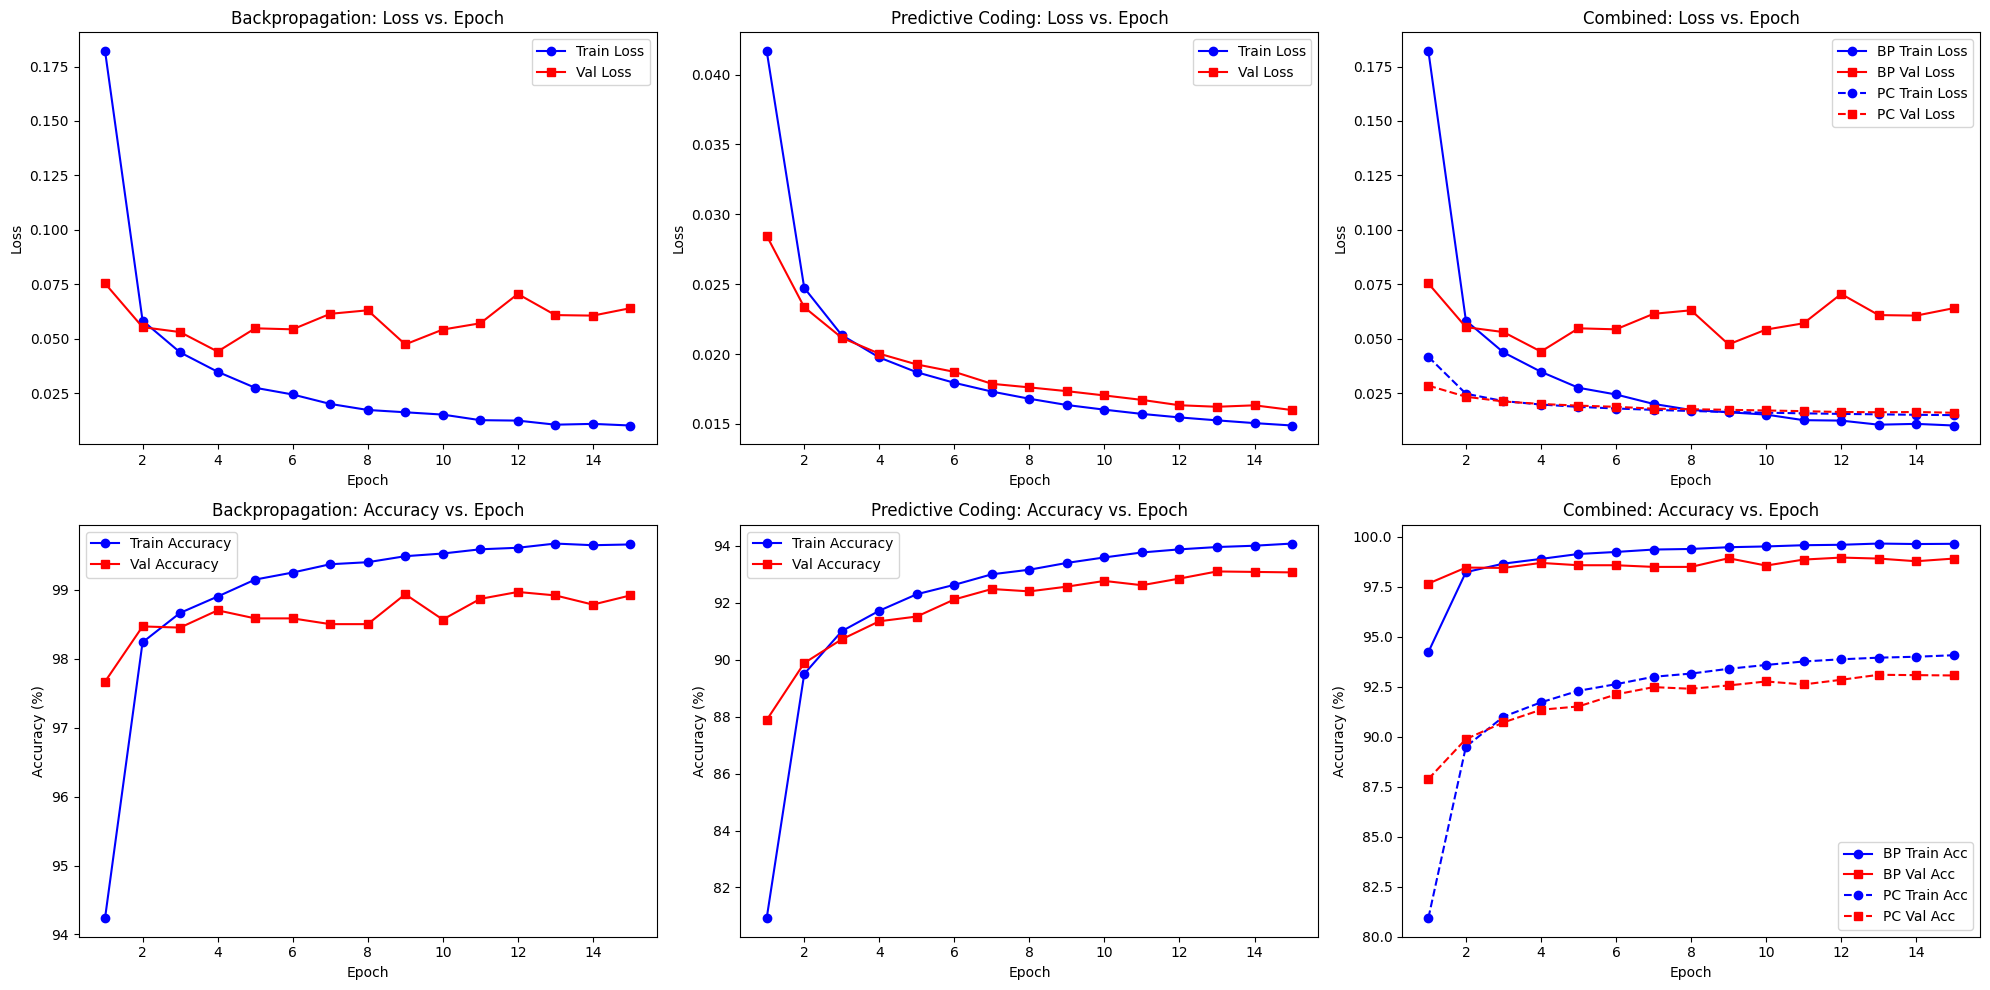

In [44]:
plot_comparison(bp_history, pc_history)

# RDM

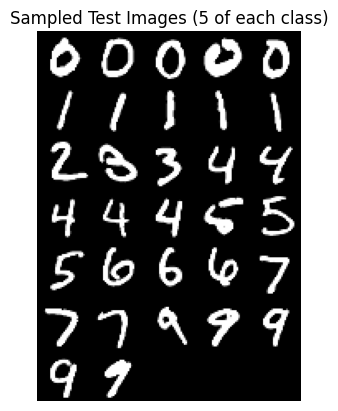

In [45]:
imgs, targets = sample_images(test_loader, n=5, plot=True)

In [46]:
print("Extracting features from Backpropagation Model...")
layer_names = [0, 1, 2, 3, 4]
bp_features = extract_features(bp_model, imgs.to(device), return_layers=layer_names)

print("\nExtracting features from Predictive Coding Model...")
pc_features = extract_features(pc_model, imgs.to(device), return_layers=layer_names)

Extracting features from Backpropagation Model...

Extracting features from Predictive Coding Model...


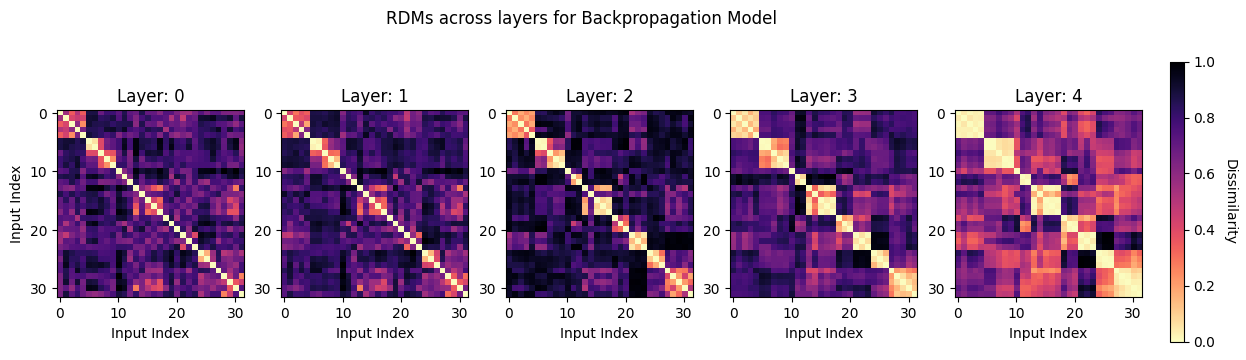

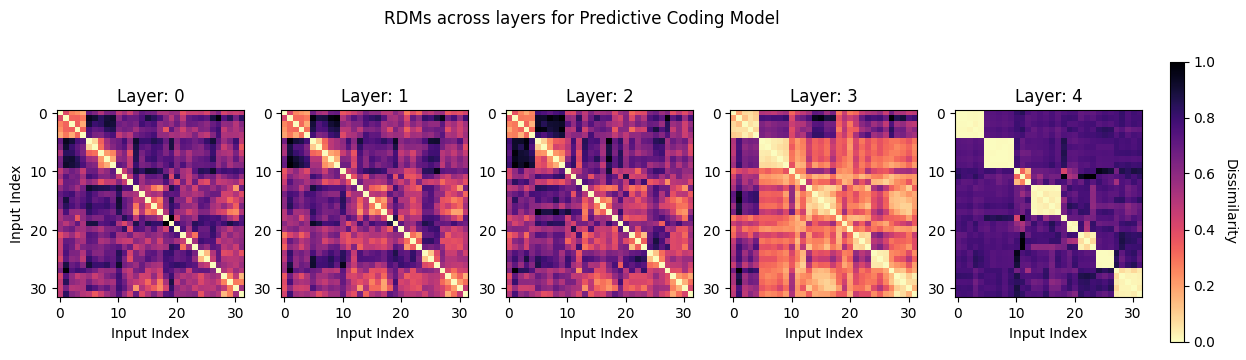

In [47]:
rdms_bp, rdms_dict_bp = calc_rdms(bp_features)
plot_maps(rdms_dict_bp, "Backpropagation Model")

rdms_pc, rdms_dict_pc = calc_rdms(pc_features)
plot_maps(rdms_dict_pc, "Predictive Coding Model")

In [48]:
def plot_dim_reduction(model_features, labels, transformer_funcs):
    """
    Plots the dimensionality reduction results for model features using various transformers.

    Inputs:
    - model_features (dict): Dictionary containing model features for each layer.
    - labels (array-like): Array of labels corresponding to the model features.
    - transformer_funcs (list): List of dimensionality reduction techniques to apply ('PCA', 'MDS', 't-SNE').
    """
    with plt.xkcd():

        transformers = []
        for t in transformer_funcs:
            if t == "PCA":
                transformers.append(PCA(n_components=2))
            if t == "MDS":
                transformers.append(
                    manifold.MDS(n_components=2, normalized_stress="auto")
                )
            if t == "t-SNE":
                transformers.append(
                    manifold.TSNE(n_components=2, perplexity=40, verbose=0)
                )

        fig = plt.figure(figsize=(8, 2.5 * len(transformers)))
        # and we add one plot per reference point
        gs = fig.add_gridspec(len(transformers), len(model_features))
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        return_layers = list(model_features.keys())

        for f in range(len(transformer_funcs)):

            for l in range(len(return_layers)):
                layer = return_layers[l]
                feats = model_features[layer].detach().cpu().flatten(1)
                feats_transformed = transformers[f].fit_transform(feats)

                amin, amax = feats_transformed.min(), feats_transformed.max()
                amin, amax = (amin + amax) / 2 - (amax - amin) * 5 / 8, (
                    amin + amax
                ) / 2 + (amax - amin) * 5 / 8
                ax = plt.subplot(gs[f, l])
                ax.set_xlim([amin, amax])
                ax.set_ylim([amin, amax])
                ax.axis("off")
                # ax.set_title(f'{layer}')
                if f == 0:
                    ax.text(
                        0.5,
                        1.12,
                        f"{layer}",
                        size=16,
                        ha="center",
                        transform=ax.transAxes,
                    )
                if l == 0:
                    ax.text(
                        -0.3,
                        0.5,
                        transformer_funcs[f],
                        size=16,
                        ha="center",
                        transform=ax.transAxes,
                    )
                # Create a discrete color map based on unique labels
                num_colors = len(np.unique(labels))
                cmap = plt.get_cmap("viridis_r", num_colors)  # 10 discrete colors
                norm = mpl.colors.BoundaryNorm(np.arange(-0.5, num_colors), cmap.N)
                ax_ = ax.scatter(
                    feats_transformed[:, 0],
                    feats_transformed[:, 1],
                    c=labels,
                    cmap=cmap,
                    norm=norm,
                )

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
        fig.colorbar(ax_, cax=cbar_ax, ticks=np.linspace(0, 9, 10))
        plt.show()

In [49]:
# ==============================================================================
# 1. Add this new helper function to your notebook first
# ==============================================================================
# REPLACE your get_balanced_test_set function with this one


def get_balanced_test_set(test_dataset, n_per_class):
    """
    Guarantees a balanced sample of n images per class from the test set.
    """
    all_imgs = []
    all_labels = []
    targets = test_dataset.targets
    for i in range(10):  # For each class from 0 to 9
        class_indices = (targets == i).nonzero(as_tuple=True)[0]
        selected_indices = class_indices[:n_per_class]
        all_imgs.append(test_dataset.data[selected_indices])
        all_labels.extend([i] * n_per_class)

    # --- THIS PART IS FIXED ---
    # Concatenate the list of tensors into one
    final_imgs = torch.cat(all_imgs, dim=0)

    # Manually convert to float, scale pixels to [0,1], and add channel dimension
    final_imgs = final_imgs.float().div(255).unsqueeze(1)
    # -------------------------

    # Apply the rest of the transformations (Resize and Normalize)
    final_imgs = transforms.Compose(
        [transforms.Resize((32, 32)), transforms.Normalize((0.1307,), (0.3081,))]
    )(final_imgs)

    final_labels = torch.tensor(all_labels)

    return final_imgs, final_labels


# ==============================================================================
# 2. Now run your analysis using this new function
# ==============================================================================

# Get a guaranteed balanced set of 500 images AND 500 labels
# analysis_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)
# imgs, labels = get_balanced_test_set(analysis_test_dataset, n_per_class=50)

# Use the correct keys for YOUR model
# return_layers = ['input_1', 1, 2, 3, 4]

# --- This code will now work because 'imgs' and 'labels' are both size 500 ---

# Extract features and plot for the BP model
# print("--- Visualizing Backpropagation Model Representations ---")
# bp_model_features = extract_features(bp_model, imgs.to(device), return_layers)
# plot_dim_reduction(bp_model_features, labels, transformer_funcs=['PCA', 'MDS', 't-SNE'])

# Extract features and plot for the PC model
# print("\n--- Visualizing Predictive Coding Model Representations ---")
# pc_model_features = extract_features(pc_model, imgs.to(device), return_layers)
# plot_dim_reduction(pc_model_features, labels, transformer_funcs=['PCA', 'MDS', 't-SNE'])

--- Visualizing Backpropagation Model Representations ---


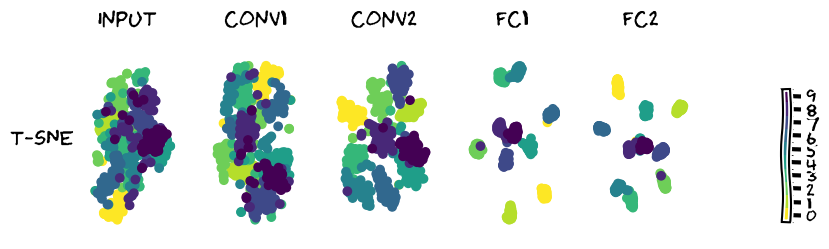


--- Visualizing Predictive Coding Model Representations ---


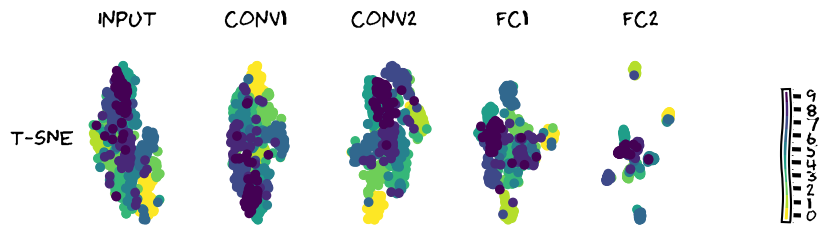

In [50]:
# --- Dimensionality Reduction Code ---
# 1. Define the mapping using the correct names from your model's graph
return_layers_map = {
    "Input": "input",  # The correct input name
    "Conv1": "0.2",  # Output of first MaxPool
    "Conv2": "1.2",  # Output of second MaxPool
    "FC1": "3.1",  # Output of the second main ReLU
    "FC2": "4.0",  # Output of the final Linear layer
}

# 2. Get the list of ACTUAL node names to pass to the function
actual_node_names = list(return_layers_map.values())

# 3. Get balanced data
analysis_test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True
)
imgs, labels = get_balanced_test_set(analysis_test_dataset, n_per_class=50)

# --- This code will now work correctly ---

# 4. Extract features using the list of actual names
print("--- Visualizing Backpropagation Model Representations ---")
bp_features_raw = extract_features(bp_model, imgs.to(device), actual_node_names)

# 5. Remap the output keys to your custom names for plotting
bp_model_features = {
    custom_name: bp_features_raw[actual_name]
    for custom_name, actual_name in return_layers_map.items()
}
plot_dim_reduction(bp_model_features, labels, transformer_funcs=["t-SNE"])

# --- Repeat for the PC model ---
print("\n--- Visualizing Predictive Coding Model Representations ---")
pc_features_raw = extract_features(pc_model, imgs.to(device), actual_node_names)
pc_model_features = {
    custom_name: pc_features_raw[actual_name]
    for custom_name, actual_name in return_layers_map.items()
}
plot_dim_reduction(pc_model_features, labels, transformer_funcs=["t-SNE"])

In [51]:
import rsatoolbox
from sklearn import manifold
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

Step 1: Preparing a balanced test set...
Data is ready.

Step 2: Extracting features from both models...
Feature extraction complete.

Step 3: Preparing data for plotting...

Step 4: Generating the representational path plot...


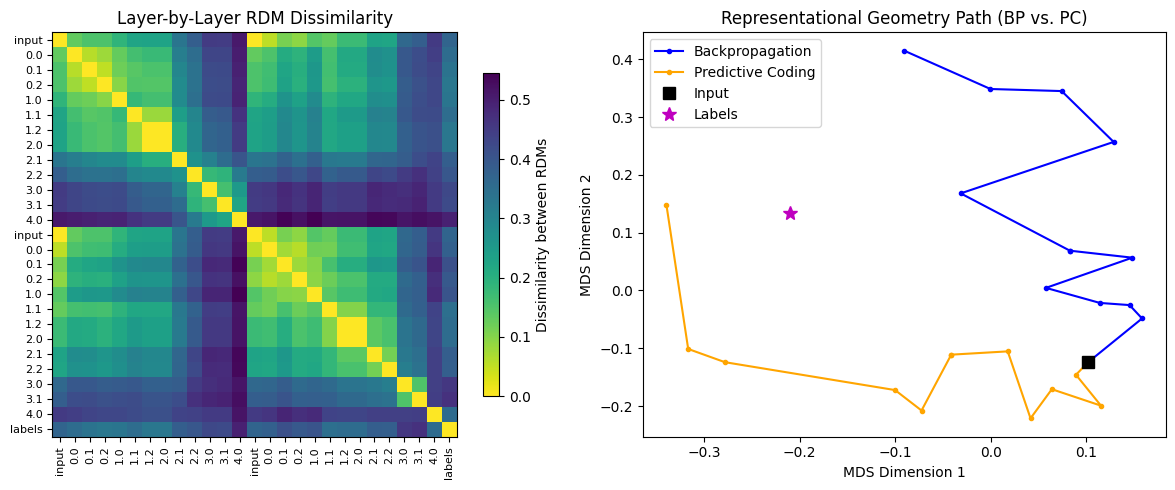

Analysis complete.


In [52]:
# 1. Get a guaranteed balanced set of 500 images and labels
print("Step 1: Preparing a balanced test set...")
analysis_test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True
)
imgs, labels = get_balanced_test_set(analysis_test_dataset, n_per_class=50)
imgs_cuda = imgs.to(device)
labels_cuda = labels.to(device)
print("Data is ready.")

# 2. Automatically get ALL layer names from your model for feature extraction
all_node_names, _ = get_graph_node_names(bp_model)

# 3. Extract features from ALL layers for both of your models
print("\nStep 2: Extracting features from both models...")
bp_features_all = extract_features(bp_model, imgs_cuda, return_layers=all_node_names)
pc_features_all = extract_features(pc_model, imgs_cuda, return_layers=all_node_names)
print("Feature extraction complete.")

# 4. Prepare the data structures for the plotting function
print("\nStep 3: Preparing data for plotting...")
features_to_compare = {
    "Backpropagation": bp_features_all,
    "Predictive Coding": pc_features_all,
}
model_colors_to_compare = {"Backpropagation": "b", "Predictive Coding": "orange"}

# 5. Generate and display the Representational Path plot
print("\nStep 4: Generating the representational path plot...")
rep_path(features_to_compare, model_colors_to_compare, labels_cuda)
print("Analysis complete.")

In [55]:
# Add these specific imports with your other imports at the top of the notebook
from rsatoolbox.util.inference_util import all_tests, get_errorbars
from rsatoolbox.util.rdm_utils import batch_to_vectors
import plotly.graph_objects as go
from copy import deepcopy
from plotly.subplots import make_subplots
import plotly

# Add these helper functions to your notebook


def _get_model_comp_descr(
    test_type,
    n_models,
    multiple_pair_testing,
    alpha,
    n_bootstraps,
    cv_method,
    error_bars,
    test_above_0,
    test_below_noise_ceil,
):
    """Constructs the statistics description string."""
    # This is a helper function from the tutorial to generate figure captions.
    # For brevity, we'll return a simplified description.
    return f"Model comparisons: {test_type}, alpha={alpha}, multiple-testing correction={multiple_pair_testing}"


def plot_metroplot_plotly(original_fig, significant, perf, models, sampled_colors):
    """Plots the metro-style significance lines."""
    fig = deepcopy(original_fig)
    n_models = len(models)
    model_names = [m.name for m in models]

    for i, model in enumerate(model_names):
        j_worse = np.where((perf[i] > perf) & significant[i, :])[0]
        if len(j_worse) == 0:
            continue

        worse_models = [model_names[j] for j in j_worse]
        metropoints = sorted(worse_models + [model], key=model_names.index)
        marker_colors = [
            "white" if point != model else sampled_colors[i] for point in metropoints
        ]

        fig.add_trace(
            go.Scatter(
                x=metropoints,
                y=[model] * len(metropoints),
                mode="lines+markers",
                marker=dict(
                    color=marker_colors,
                    symbol="circle",
                    size=10,
                    line=dict(width=2, color=sampled_colors[i]),
                ),
                line=dict(width=2, color=sampled_colors[i]),
                showlegend=False,
            ),
            row=1,
            col=1,
        )
    return fig


# REPLACE your plot_model_comparison_trans function with this final version


# Make sure this import is available for the function
from rsatoolbox.util.inference_util import t_tests, t_test_0


def plot_model_comparison_trans(
    result, alpha=0.05, test_type="t-test", multiple_pair_testing="fdr"
):
    """
    Plots model evaluation results. This version is corrected to NOT require a noise ceiling.
    """
    evaluations = result.evaluations
    models = result.models
    model_var = result.model_var
    diff_var = result.diff_var
    dof = result.dof
    n_models = len(models)

    perf = np.mean(evaluations, axis=0)

    # --- THIS IS THE FIX ---
    # We call the underlying tests directly, skipping the noise ceiling test which causes the error.
    p_pairwise = t_tests(evaluations, diff_var, dof=dof)
    p_zero = t_test_0(evaluations, model_var, dof=dof)
    # ----------------------

    limits = get_errorbars(model_var, evaluations, dof, "sem", test_type)[0]

    fig = make_subplots(
        rows=2, cols=1, row_heights=[0.4, 0.6], vertical_spacing=0.05, shared_xaxes=True
    )

    color_scale = plotly.colors.get_colorscale("Bluered")
    color_indices = np.linspace(0, 1, n_models)
    sampled_colors = plotly.colors.sample_colorscale(color_scale, color_indices)

    fig.add_trace(
        go.Bar(
            x=[m.name for m in models],
            y=perf,
            error_y=dict(type="data", array=limits, visible=True),
            marker_color=sampled_colors,
        ),
        row=2,
        col=1,
    )

    if multiple_pair_testing.lower() == "fdr":
        ps = batch_to_vectors(np.array([p_pairwise]))[0][0]
        ps_sorted = np.sort(ps)
        criterion = alpha * (np.arange(len(ps)) + 1) / len(ps)
        k_ok = ps_sorted < criterion
        crit = criterion[np.max(np.where(k_ok)[0])] if np.any(k_ok) else 0
        significant = p_pairwise < crit
    else:
        n_tests = n_models * (n_models - 1) / 2
        p_crit = (
            alpha / n_tests
            if multiple_pair_testing.lower() in ["bonferroni", "fwer"]
            else alpha
        )
        significant = p_pairwise < p_crit

    fig = plot_metroplot_plotly(fig, significant, perf, models, sampled_colors)

    fig.update_layout(
        height=700,
        showlegend=False,
        template="plotly_white",
        title_text="Model Performance vs. Target Labels RDM",
        yaxis2_title="RDM Prediction Accuracy (Correlation)",
    )
    fig.show()

In [58]:
# ==============================================================================
# Final Statistical Comparison using a Neutral "Labels" Benchmark (Corrected)
# ==============================================================================

import rsatoolbox as rsa

# 1. Get the balanced set of 500 images and labels
analysis_test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True
)
imgs, labels = get_balanced_test_set(analysis_test_dataset, n_per_class=50)
imgs_cuda = imgs.to(device)
labels_cuda = labels.to(device)

# 2. Extract features from all layers for both of your models
all_node_names, _ = get_graph_node_names(bp_model)
bp_features_all = extract_features(bp_model, imgs_cuda, return_layers=all_node_names)
pc_features_all = extract_features(pc_model, imgs_cuda, return_layers=all_node_names)

# --- THIS IS THE FIX ---
# 3. Create RDM objects using your helper function `calc_rdms` (with an 's')
bp_rdms, _ = calc_rdms(bp_features_all, method="correlation")
pc_rdms, _ = calc_rdms(pc_features_all, method="correlation")
# --------------------

# 4. Set the "Target RDM" to be the ideal RDM from the class labels
labels_rdm_obj, _ = calc_rdms(
    {"labels": F.one_hot(labels_cuda).float()}, method="correlation"
)
labels_rdm_obj.rdm_descriptors["layer"] = ["Target Labels"]
target_rdm = labels_rdm_obj

# 5. Create a list of all layers from all models to serve as "Candidate Models"
candidate_models = []
# Add all layers from the BP model
for i, layer_name in enumerate(all_node_names):
    rdm = bp_rdms.subset("layer", layer_name)
    candidate_models.append(rsa.model.ModelFixed(rdm=rdm, name=f"BP_Layer_{i}"))

# Add all layers from the PC model
for i, layer_name in enumerate(all_node_names):
    rdm = pc_rdms.subset("layer", layer_name)
    candidate_models.append(rsa.model.ModelFixed(rdm=rdm, name=f"PC_Layer_{i}"))

# 6. Perform statistical evaluation using bootstrapping
eval_result = rsa.inference.eval_bootstrap_pattern(
    models=candidate_models, data=target_rdm, method="corr", N=100
)

# 7. Visualize the results
print("\n--- Statistical Comparison of Layer Representations against Ideal Labels ---")

100%|██████████| 100/100 [00:13<00:00,  7.59it/s]


--- Statistical Comparison of Layer Representations against Ideal Labels ---


In [59]:
plot_model_comparison_trans(eval_result)

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Use the same model architecture from your notebook


def create_model():
    return nn.Sequential(
        nn.Sequential(nn.Conv2d(1, 6, 5), nn.ReLU(), nn.MaxPool2d(2, 2)),
        nn.Sequential(nn.Conv2d(6, 16, 5), nn.ReLU(), nn.MaxPool2d(2)),
        nn.Sequential(nn.Flatten(), nn.Linear(16 * 5 * 5, 120), nn.ReLU()),
        nn.Sequential(nn.Linear(120, 84), nn.ReLU()),
        nn.Sequential(nn.Linear(84, 10)),
    )


# Helper function to create DataLoaders for specific digits


def create_task_loaders(dataset, task_digits, batch_size=64):
    """Creates a DataLoader for a subset of the dataset."""
    indices = [i for i, (_, label) in enumerate(dataset) if label in task_digits]
    subset = Subset(dataset, indices)
    return DataLoader(subset, batch_size=batch_size, shuffle=True)


# Helper function to evaluate the model


def evaluate_model(model, data_loader, task_name, device):
    """Evaluates the model's accuracy on a given task."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy on {task_name}: {accuracy:.2f}%")
    return accuracy


# ==============================================================================
# Main Experiment Script
# ==============================================================================


# 1. Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=mnist_transform, download=True
)

# 2. Create DataLoaders for Task A (digits 0-4) and Task B (digits 5-9)
task_a_loader = create_task_loaders(train_dataset, task_digits=[0, 1, 2, 3, 4])
task_b_loader = create_task_loaders(train_dataset, task_digits=[5, 6, 7, 8, 9])

# 3. Initialize Model and Optimizer
catastrophic_model = create_model().to(device)
optimizer = optim.Adam(catastrophic_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# --- TASK A: Train on digits 0-4 ---
print("--- Training on Task A (digits 0-4) ---")
catastrophic_model.train()
for epoch in range(3):  # Train for a few epochs
    for data, targets in task_a_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = catastrophic_model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
print("Task A training complete.")

# --- Evaluate after learning Task A ---
print("\n--- Evaluating after Task A ---")
evaluate_model(catastrophic_model, task_a_loader, "Task A (digits 0-4)", device)
evaluate_model(catastrophic_model, task_b_loader, "Task B (digits 5-9)", device)


# --- TASK B: Train on digits 5-9 ---
print("\n--- Training on Task B (digits 5-9) ---")
catastrophic_model.train()
for epoch in range(3):  # Train for a few epochs
    for data, targets in task_b_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = catastrophic_model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
print("Task B training complete.")

# --- Final Evaluation ---
print("\n--- Final Evaluation after Task B ---")
acc_A = evaluate_model(catastrophic_model, task_a_loader, "Task A (digits 0-4)", device)
acc_B = evaluate_model(catastrophic_model, task_b_loader, "Task B (digits 5-9)", device)

print(f"\nModel has forgotten Task A! Accuracy dropped to {acc_A:.2f}%.")

--- Training on Task A (digits 0-4) ---
Task A training complete.

--- Evaluating after Task A ---
Accuracy on Task A (digits 0-4): 99.63%
Accuracy on Task B (digits 5-9): 0.00%

--- Training on Task B (digits 5-9) ---
Task B training complete.

--- Final Evaluation after Task B ---
Accuracy on Task A (digits 0-4): 0.00%
Accuracy on Task B (digits 5-9): 99.35%

Model has forgotten Task A! Accuracy dropped to 0.00%.


In [60]:
# ==============================================================================
# Catastrophic Forgetting Experiment for the PC Model
# ==============================================================================

# 1. Setup (Helper functions and model architecture are the same as before)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=mnist_transform, download=True
)

# 2. Create DataLoaders for the two tasks
task_a_loader = create_task_loaders(train_dataset, task_digits=[0, 1, 2, 3, 4])
task_b_loader = create_task_loaders(train_dataset, task_digits=[5, 6, 7, 8, 9])

# 3. Initialize a new Model for the PC experiment
pc_catastrophic_model = create_model().to(device)
optimizer = optim.Adam(pc_catastrophic_model.parameters(), lr=0.001)
# PC uses Mean Squared Error loss against one-hot targets
criterion = nn.MSELoss()

# --- TASK A: Train PC model on digits 0-4 ---
print("--- Training PC Model on Task A (digits 0-4) ---")
pc_catastrophic_model.train()
for epoch in range(3):  # Train for a few epochs
    for data, targets in task_a_loader:
        data, targets = data.to(device), targets.to(device)
        targets_onehot = F.one_hot(targets, num_classes=10).float()

        # Use the PC training function
        _, loss, _, _, _ = T2PC.PCInfer(
            pc_catastrophic_model,
            criterion,
            data,
            targets_onehot,
            "Strict",
            eta=5e-5,
            n=5,
        )
        optimizer.step()
        optimizer.zero_grad()
print("Task A training complete.")

# --- Evaluate after learning Task A ---
print("\n--- Evaluating PC Model after Task A ---")
evaluate_model(pc_catastrophic_model, task_a_loader, "Task A (digits 0-4)", device)
evaluate_model(pc_catastrophic_model, task_b_loader, "Task B (digits 5-9)", device)


# --- TASK B: Train PC model on digits 5-9 ---
print("\n--- Training PC Model on Task B (digits 5-9) ---")
pc_catastrophic_model.train()
for epoch in range(3):  # Train for a few epochs
    for data, targets in task_b_loader:
        data, targets = data.to(device), targets.to(device)
        targets_onehot = F.one_hot(targets, num_classes=10).float()

        # Use the PC training function
        _, loss, _, _, _ = T2PC.PCInfer(
            pc_catastrophic_model,
            criterion,
            data,
            targets_onehot,
            "Strict",
            eta=5e-5,
            n=5,
        )
        optimizer.step()
        optimizer.zero_grad()
print("Task B training complete.")

# --- Final Evaluation ---
print("\n--- Final Evaluation of PC Model after Task B ---")
acc_A_pc = evaluate_model(
    pc_catastrophic_model, task_a_loader, "Task A (digits 0-4)", device
)
acc_B_pc = evaluate_model(
    pc_catastrophic_model, task_b_loader, "Task B (digits 5-9)", device
)

print(f"\nPC Model has forgotten Task A! Accuracy dropped to {acc_A_pc:.2f}%.")

--- Training PC Model on Task A (digits 0-4) ---
Task A training complete.

--- Evaluating PC Model after Task A ---
Accuracy on Task A (digits 0-4): 96.75%
Accuracy on Task B (digits 5-9): 0.00%

--- Training PC Model on Task B (digits 5-9) ---
Task B training complete.

--- Final Evaluation of PC Model after Task B ---
Accuracy on Task A (digits 0-4): 0.00%
Accuracy on Task B (digits 5-9): 94.53%

PC Model has forgotten Task A! Accuracy dropped to 0.00%.


In [ ]:
def extract_features_with_names(model, imgs, layer_name_mapping=None):
    """
    Extracts features from specified layers with meaningful names.

    Args:
        model: PyTorch model
        imgs: Input images
        layer_name_mapping: Dict mapping node names to meaningful names
                          If None, uses default CNN layer names

    Returns:
        Dictionary with meaningful layer names as keys
    """
    # Get all node names from the model
    all_node_names, _ = get_graph_node_names(model)

    # Create default meaningful names if not provided
    if layer_name_mapping is None:
        layer_name_mapping = {
            "input": "Input",
            "0.0": "Conv1_ReLU",
            "0.2": "Conv1_MaxPool",
            "1.0": "Conv2_ReLU",
            "1.2": "Conv2_MaxPool",
            "2.0": "Flatten",
            "2.1": "FC1_Linear",
            "2.2": "FC1_ReLU",
            "3.0": "FC2_Linear",
            "3.1": "FC2_ReLU",
            "4.0": "Output_Linear",
        }

    # Extract features using PyTorch's feature extractor
    feature_extractor = create_feature_extractor(model, return_nodes=all_node_names)
    raw_features = feature_extractor(imgs)

    # Remap to meaningful names, keeping only the layers we want to analyze
    meaningful_features = {}
    for node_name, features in raw_features.items():
        if node_name in layer_name_mapping:
            meaningful_name = layer_name_mapping[node_name]
            meaningful_features[meaningful_name] = features

    return meaningful_features

In [ ]:
print("Step 1: Preparing a balanced test set...")
analysis_test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True
)
imgs, labels = get_balanced_test_set(analysis_test_dataset, n_per_class=50)
imgs_cuda = imgs.to(device)
labels_cuda = labels.to(device)
print("Data is ready.")

print("\nStep 2: Extracting features with meaningful names...")

# Use the new function with meaningful layer names
bp_features_named = extract_features_with_names(bp_model, imgs_cuda)
pc_features_named = extract_features_with_names(pc_model, imgs_cuda)

print("Feature extraction complete.")

# 4. Prepare the data structures for the plotting function
print("\nStep 3: Preparing data for plotting...")
features_to_compare_named = {
    "Backpropagation": bp_features_named,
    "Predictive Coding": pc_features_named,
}
model_colors_to_compare = {"Backpropagation": "b", "Predictive Coding": "orange"}

# 5. Generate and display the Representational Path plot with named layers
print("\nStep 4: Generating the representational path plot with named layers...")
rep_path(features_to_compare_named, model_colors_to_compare, labels_cuda)
print("Analysis complete.")